⚠️ This notebook requires the mne(used for EEG/MEG data analysis) package. Run the cell below to install it if needed:

In [ ]:
!pip install mne

In [1]:
%%capture
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy as sp
import mne
import hints

In [2]:
#initialization and parameters

eeg_t1avg={}
n_subjects=109
n_groups=7
groups=pd.read_excel(r"7_regions_aggregation.xlsx")
fs=160 #sampling rate frequency

In [3]:
%%capture

#First task: two trials R07, R011

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

#butter filter
b,a=sp.signal.butter(5,[0.5,50],fs=fs,btype="band")

for i in range(n_subjects):
    if i<9:
    
        path2=r"eeg-motor-movementimagery-dataset-1.0.0\files\S00"+str(i+1)+r"\S00"+str(i+1)+r"R07.edf"
        path3=r"eeg-motor-movementimagery-dataset-1.0.0\files\S00"+str(i+1)+r"\S00"+str(i+1)+r"R11.edf"
    elif (i<99 and i>=9):
        
        path2=r"eeg-motor-movementimagery-dataset-1.0.0\files\S0"+str(i+1)+r"\S0"+str(i+1)+r"R07.edf"
        path3=r"eeg-motor-movementimagery-dataset-1.0.0\files\S0"+str(i+1)+r"\S0"+str(i+1)+r"R11.edf"
    else:
        
        path2=r"eeg-motor-movementimagery-dataset-1.0.0\files\S"+str(i+1)+r"\S"+str(i+1)+r"R07.edf"
        path3=r"eeg-motor-movementimagery-dataset-1.0.0\files\S"+str(i+1)+r"\S"+str(i+1)+r"R11.edf"    
    
    with suppress_stdout():

        edf2 = mne.io.read_raw_edf(path2)
        header2 = ','.join(edf2.ch_names)
        data2=edf2.get_data().T

        edf3 = mne.io.read_raw_edf(path3)
        header3 = ','.join(edf3.ch_names)
        data3=edf3.get_data().T

    data=(data2[0:16690,:]+data3[0:16690,:])/2
    

    eeg_t1avg[i]={}

    for j in range(n_groups):

        eeg_t1avg[i][j]=[]
        for k in range(len(groups.iloc[:,j])):
            if groups.iloc[k,j]>0:
                eeg_t1avg[i][j].append(data[:,int(groups.iloc[k,j])-1])

        s=0*eeg_t1avg[i][0][0]

        for k in range(len(eeg_t1avg[i][j])):
            s=s+eeg_t1avg[i][j][k]

        s=s/len(eeg_t1avg[i][j])

        s=sp.signal.lfilter(b,a,x=s)    

        s=(s-np.mean(s))/np.std(s)

        eeg_t1avg[i][j]=s

    eeg_t1avg[i]=(pd.DataFrame(eeg_t1avg[i])).values 
    
    del data,data2,data3      

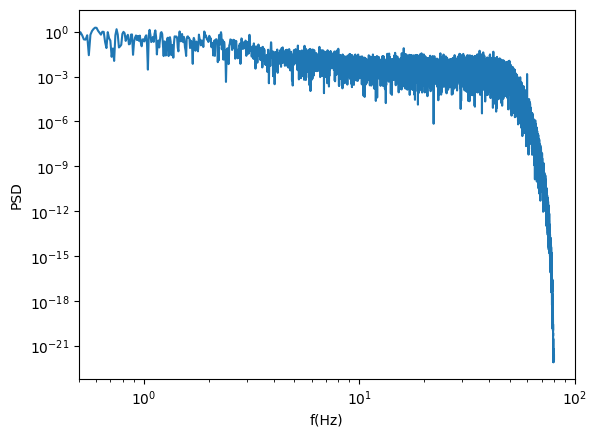

In [5]:
sig=eeg_t1avg[10][:,3]

f,ps=sp.signal.welch(sig-np.mean(sig),fs=fs,nperseg=len(sig))


plt.figure()
plt.plot(f,ps)
plt.xlim(0.5,100)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("PSD")
plt.xlabel("f(Hz)")
plt.show()

In [6]:
drift_models=[]

coeff_labels=[]

for i in range(n_subjects):
    
    if i==0:
        model=hints.kmcc(ts_array=eeg_t1avg[i],dt=1/fs,interaction_order=[1,2],estimation_mode="drift")
        coeff_labels=model._construct_keys() 
        drift_models.append(model.get_coefficients())
        
        del model

    else:
        drift_models.append((hints.kmcc(ts_array=eeg_t1avg[i],dt=1/fs,interaction_order=[1,2],estimation_mode="drift")).get_coefficients())




In [5]:
#artifact removal
subjects=[]
eeg_subjects=[]

for i in range(n_subjects):
    if np.max(np.abs(drift_models[i].values))<=40:
        subjects.append(i+1)
        eeg_subjects.append(drift_models[i])

print("Number of remaining subjects after articact removal = ",len(eeg_subjects))

Number of remaining subjects after articact removal =  95


In [6]:
n_ensemble=len(eeg_subjects)

In [7]:
#Pair-wise matrix derivation

pair_wise_mean=np.zeros((n_groups,n_groups))
pair_wise_sem=np.zeros((n_groups,n_groups))

for i in range(n_ensemble):
    pair_wise_mean=pair_wise_mean+eeg_subjects[i].values[0:7,0:7]

pair_wise_mean=pair_wise_mean/n_subjects

for i in range(n_ensemble):
    pair_wise_sem=pair_wise_sem+(eeg_subjects[i].values[0:7,0:7]-pair_wise_mean)**2

pair_wise_sem=np.sqrt(pair_wise_sem/(n_ensemble*(n_ensemble-1)))
    

Text(0.5, 1.1, 'SEM over 95 subjects')

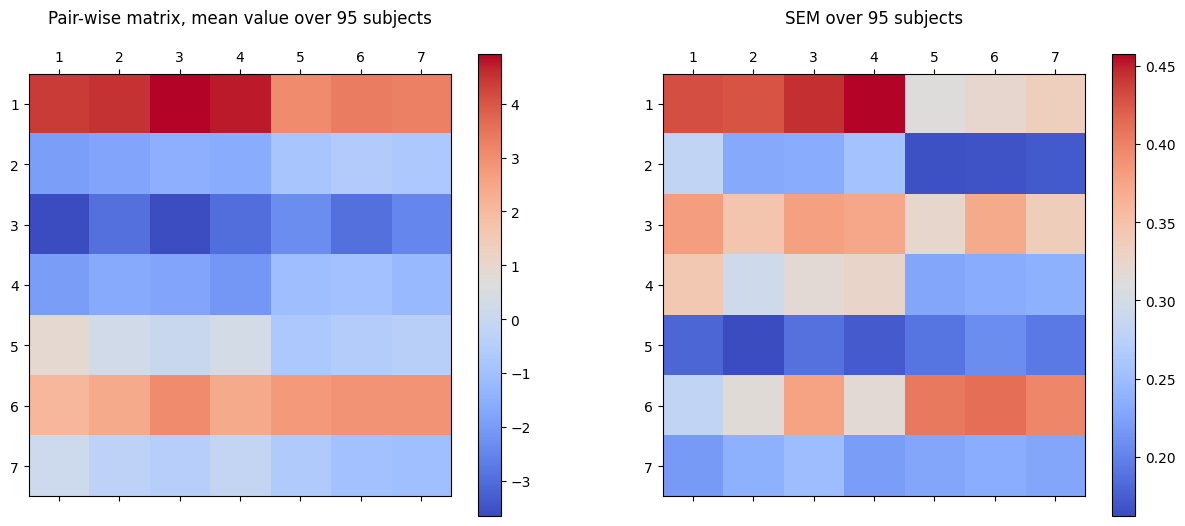

In [8]:
plt.figure(figsize=(15,6))

ax1=plt.subplot(1,2,1)

im1=plt.imshow(pair_wise_mean,"coolwarm")
plt.xticks(np.arange(0,7),np.arange(1,8))
plt.yticks(np.arange(0,7),np.arange(1,8))
plt.colorbar(im1)

ax1.tick_params(top=True, labeltop=True, bottom=True, labelbottom=False)

ax1.set_title("Pair-wise matrix, mean value over 95 subjects", y=1.1)

ax2=plt.subplot(1,2,2)

im2=plt.imshow(pair_wise_sem,"coolwarm")
plt.xticks(np.arange(0,7),np.arange(1,8))
plt.yticks(np.arange(0,7),np.arange(1,8))
plt.colorbar(im2)

ax2.tick_params(top=True,labeltop=True,bottom=True,labelbottom=False)

ax2.set_title("SEM over 95 subjects", y=1.1)

Text(0, 0.5, 'Imaginary part')

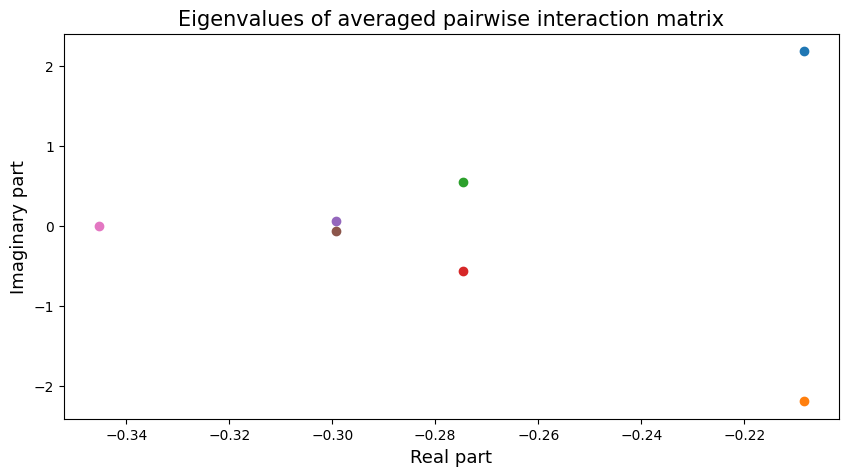

In [9]:
#eigenvalue plot

eigvalues=sp.linalg.eigvals(pair_wise_mean)


plt.figure(figsize=(10,5))
for re,im in zip(np.real(eigvalues),np.imag(eigvalues)):

    plt.scatter(re,im)
    

plt.title("Eigenvalues of averaged pairwise interaction matrix",fontsize=15)
plt.xlabel("Real part",fontsize=13)
plt.ylabel("Imaginary part",fontsize=13)   



In [10]:
print(sp.linalg.eigvals(pair_wise_mean))

[-0.20849056+2.18750268j -0.20849056-2.18750268j -0.27461865+0.55472669j
 -0.27461865-0.55472669j -0.29932532+0.06438415j -0.29932532-0.06438415j
 -0.34527162+0.j        ]


(array([-10.,  -8.,  -6.,  -4.,  -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 [Text(0, -10.0, '−10'),
  Text(0, -8.0, '−8'),
  Text(0, -6.0, '−6'),
  Text(0, -4.0, '−4'),
  Text(0, -2.0, '−2'),
  Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10')])

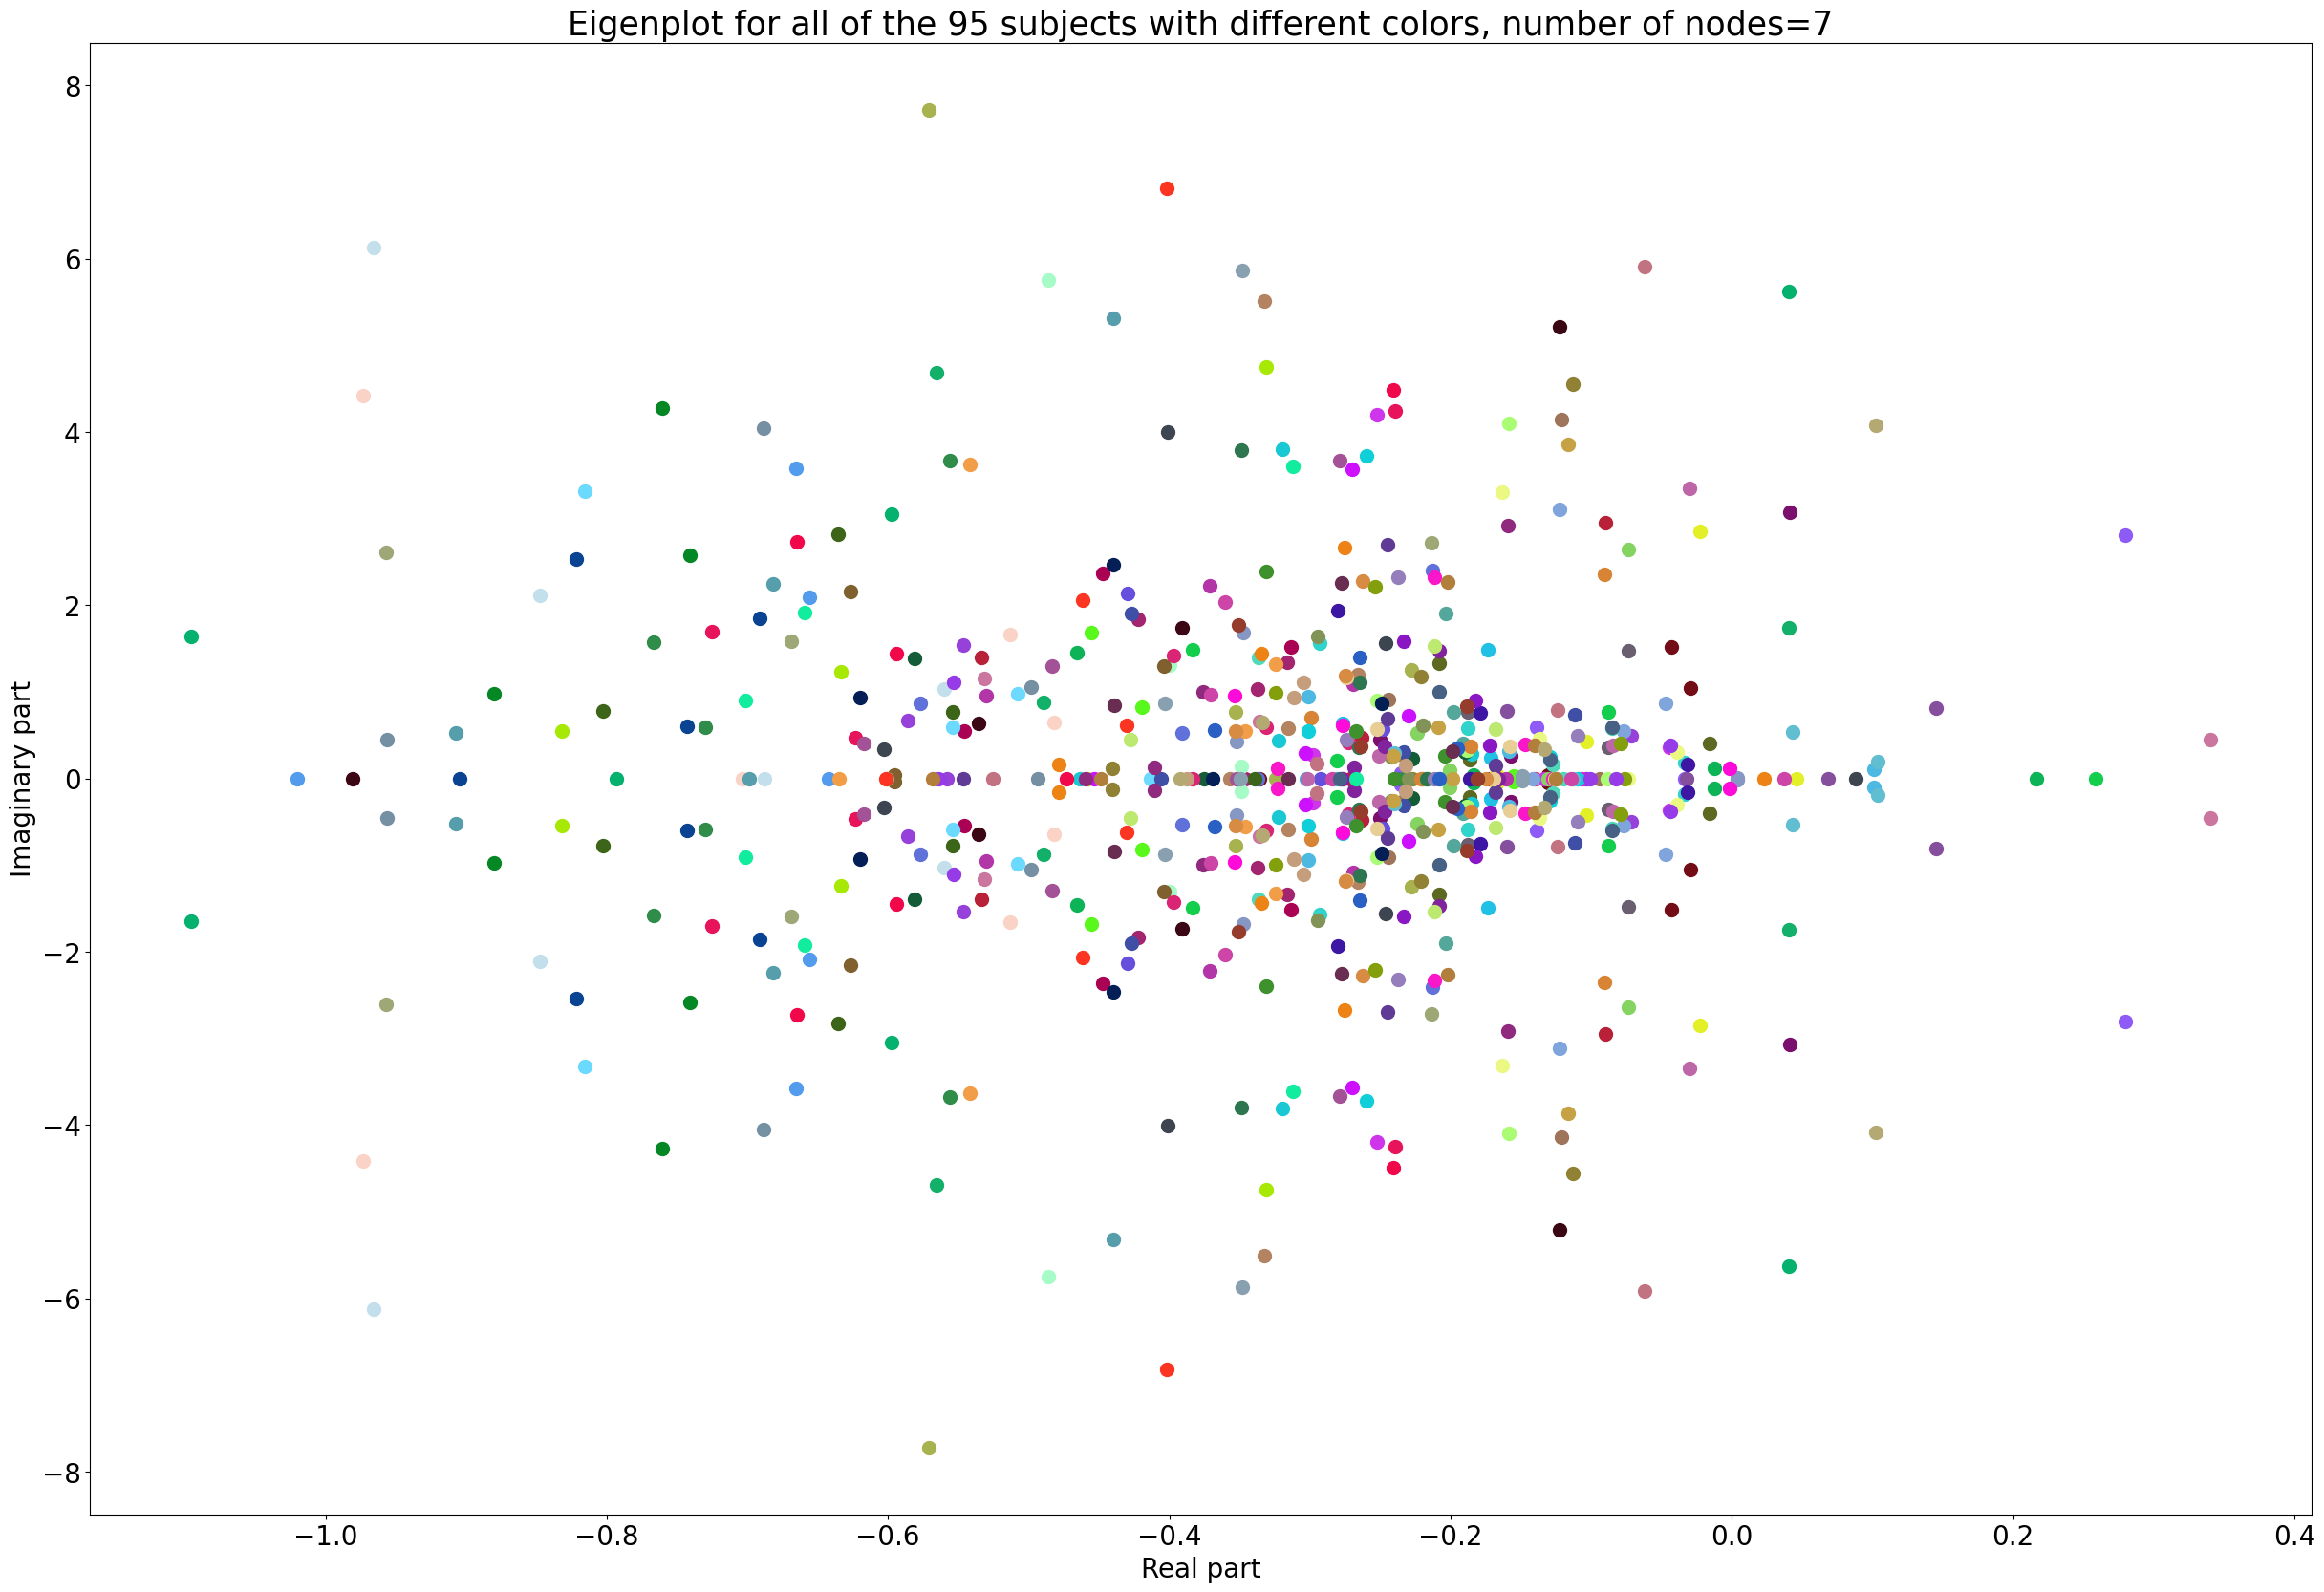

In [ ]:
#Eigenplot of all subjects

plt.figure(figsize=(30,20))

for i in range(n_ensemble):

    eigs=sp.linalg.eigvals(eeg_subjects[i].values[0:7,0:7])

    plt.scatter(np.real(eigs),np.imag(eigs),c=color[i],s=100)

plt.title("Eigenplot for all of the 95 subjects with different colors, number of nodes=7",fontsize=25)
plt.xlabel("Real part",fontsize=20)
plt.ylabel("Imaginary part",fontsize=20)  

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_10768\3528763108.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,3))


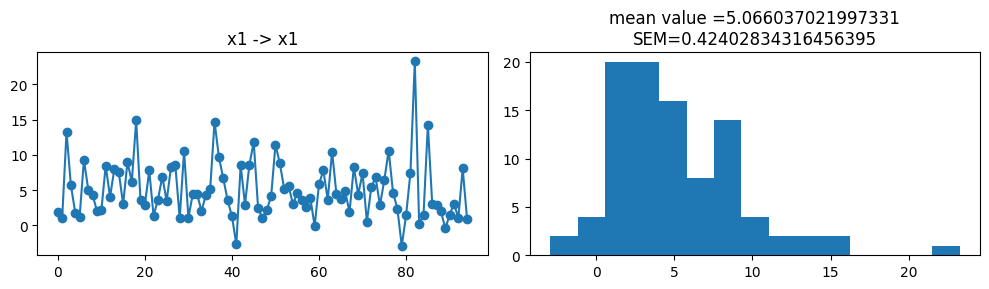

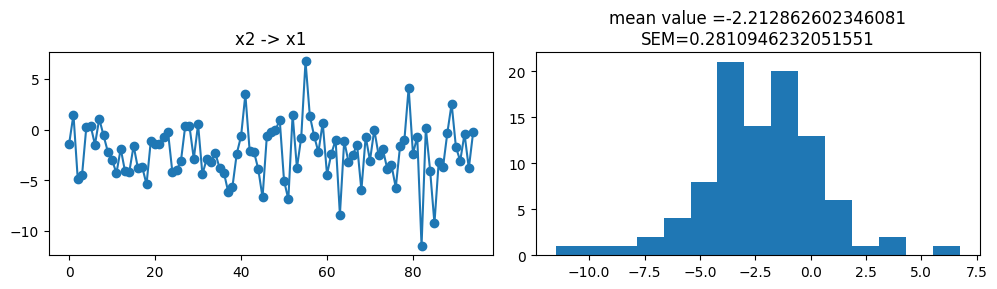

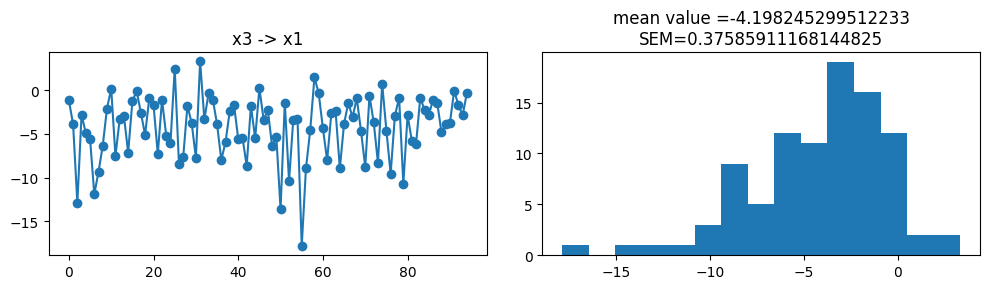

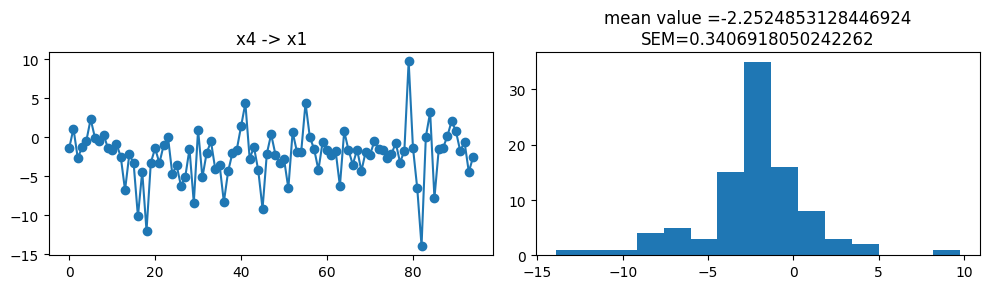

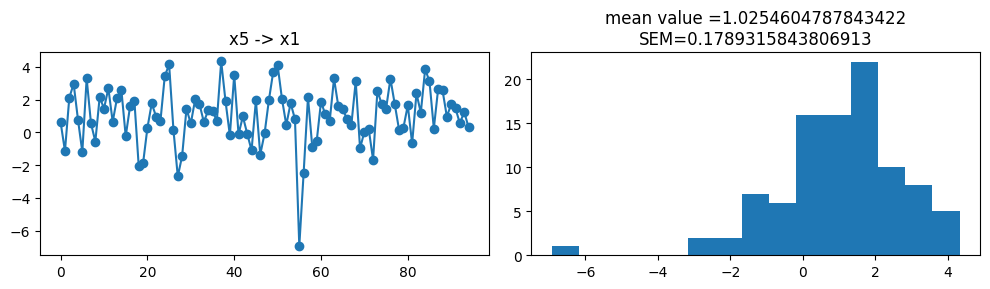

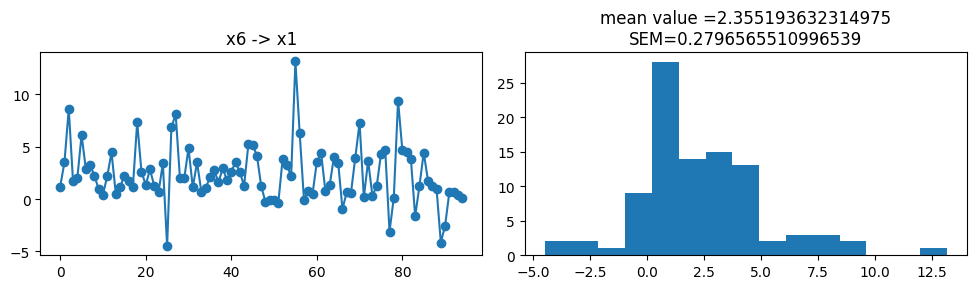

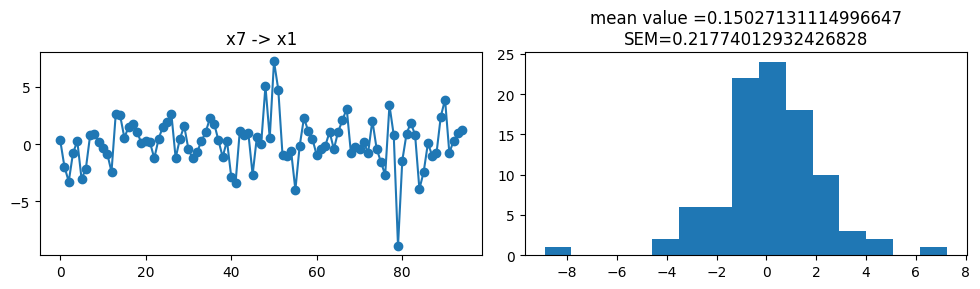

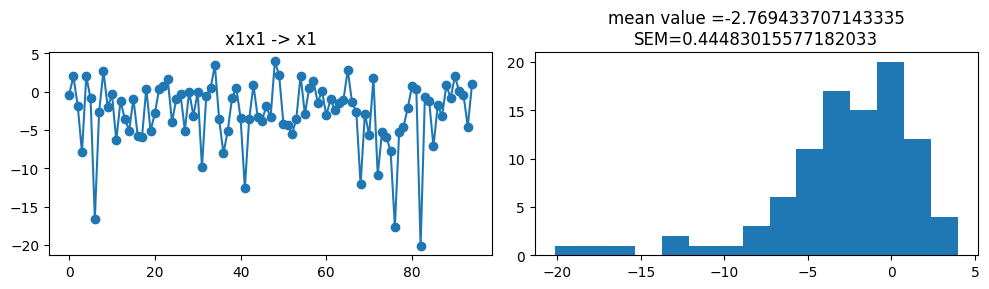

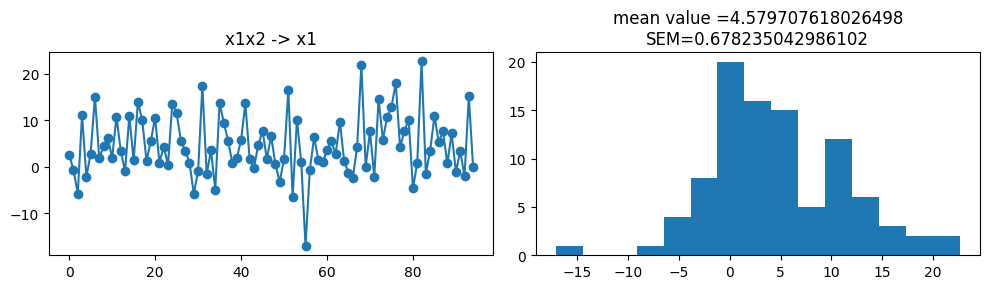

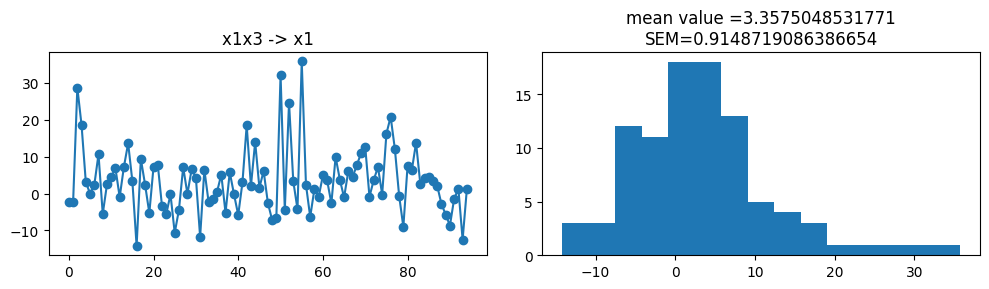

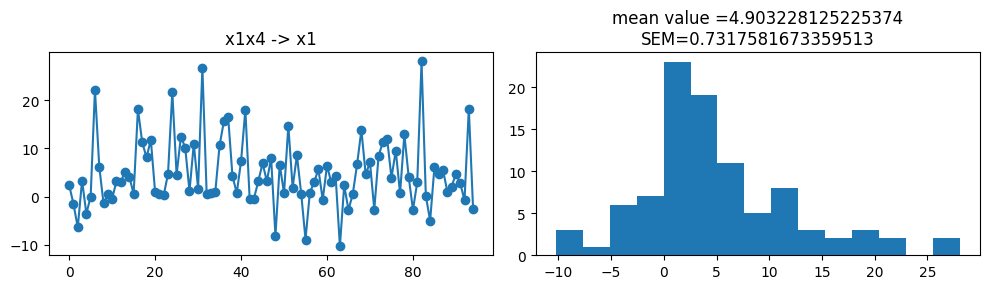

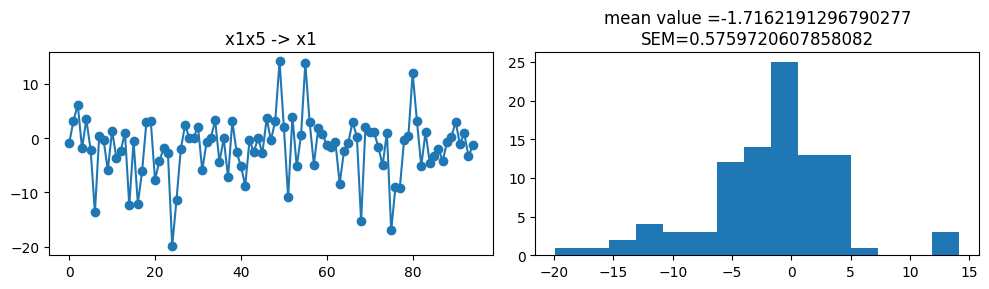

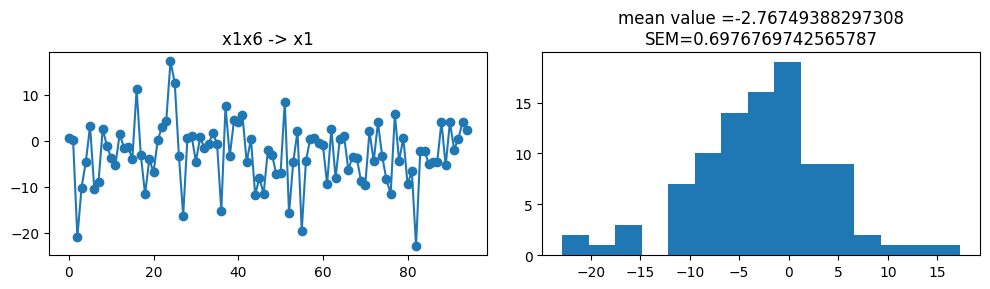

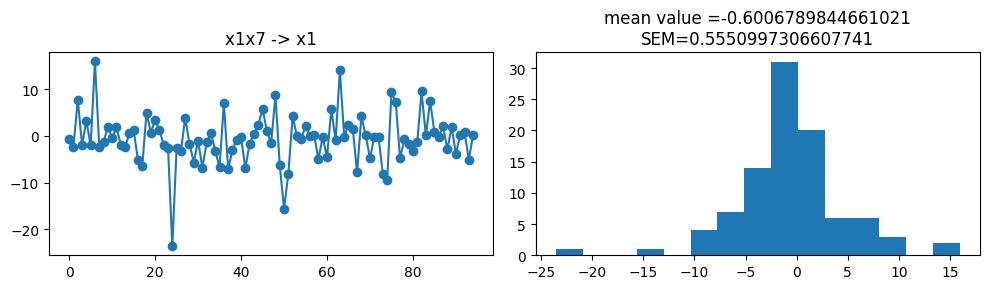

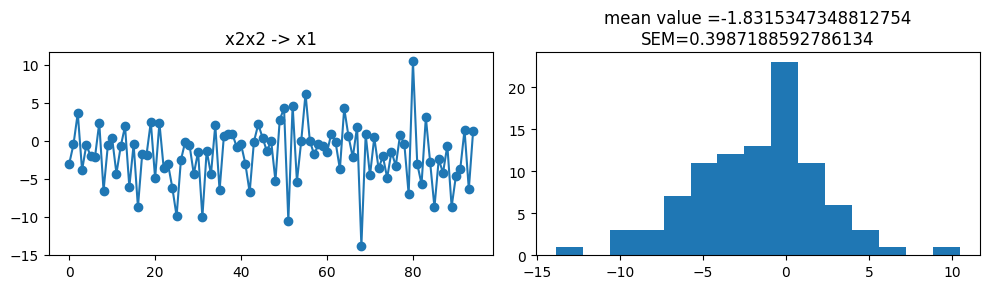

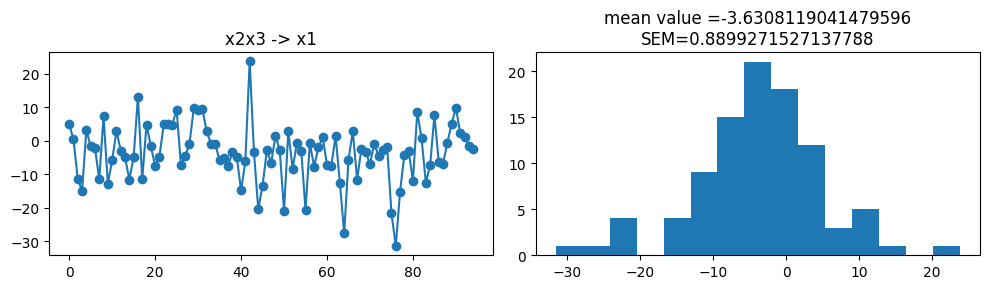

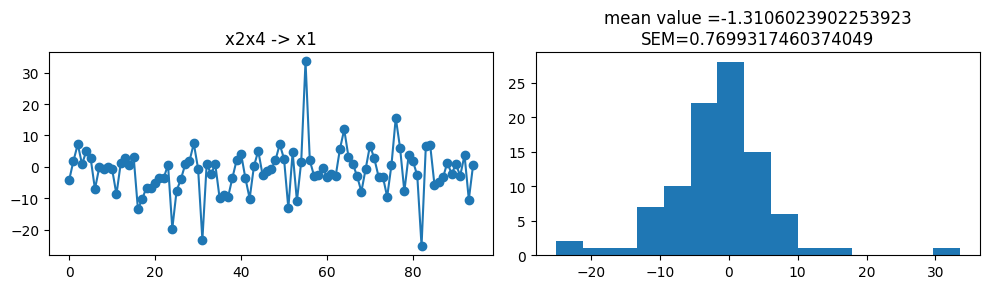

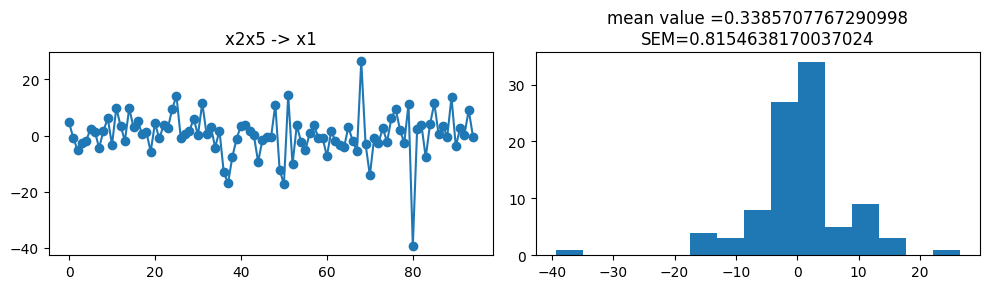

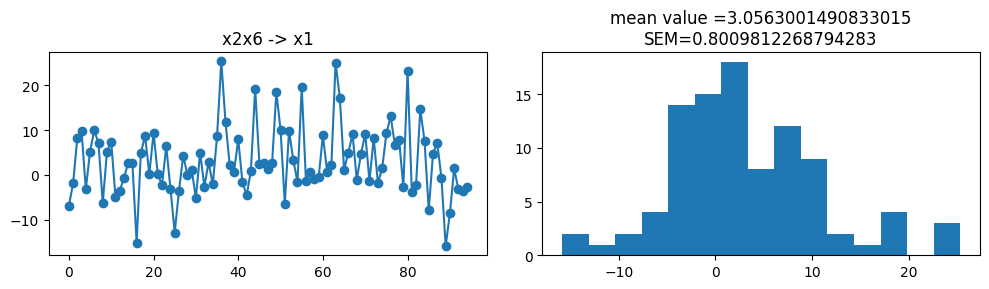

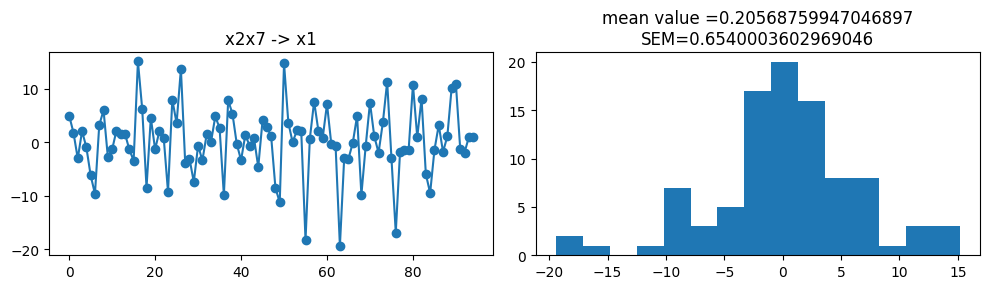

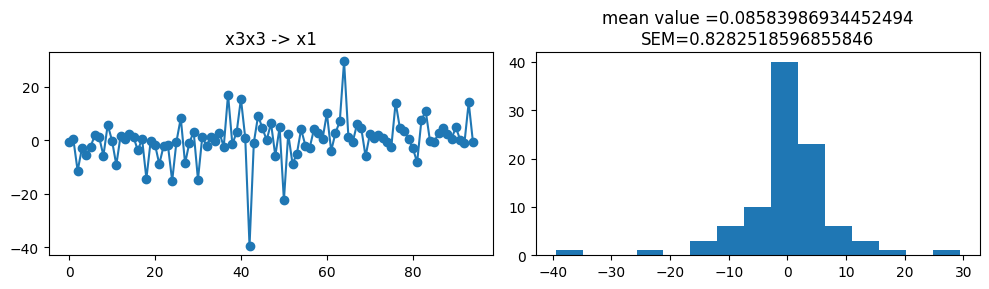

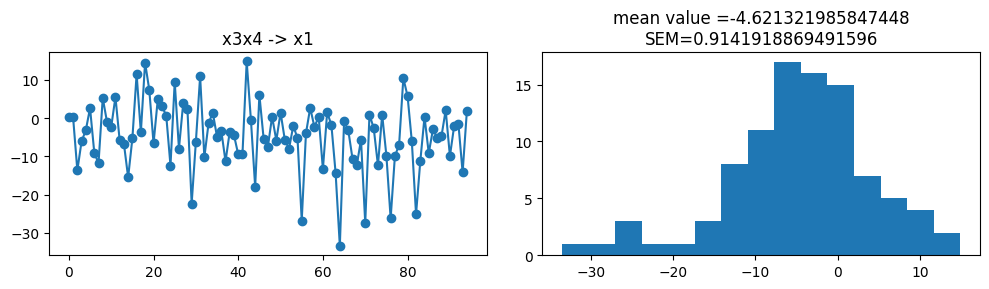

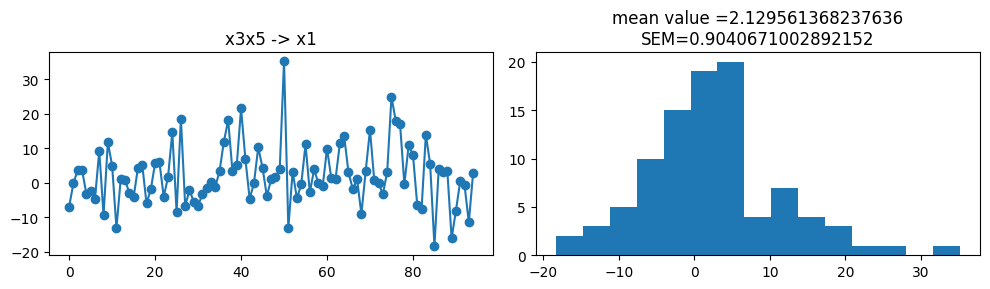

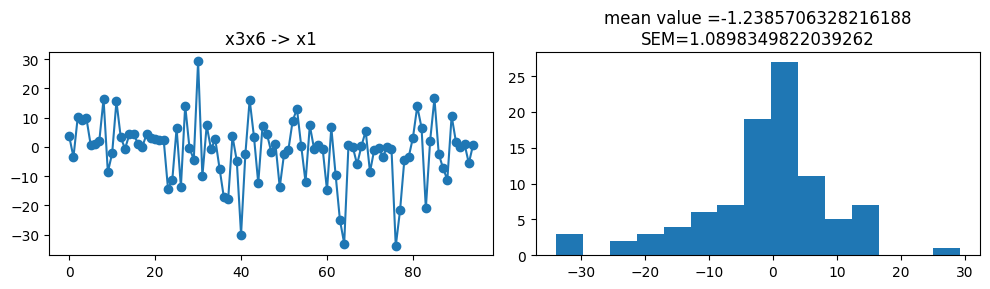

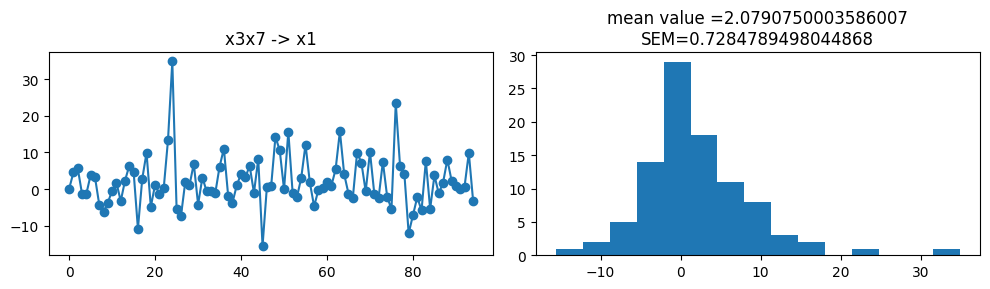

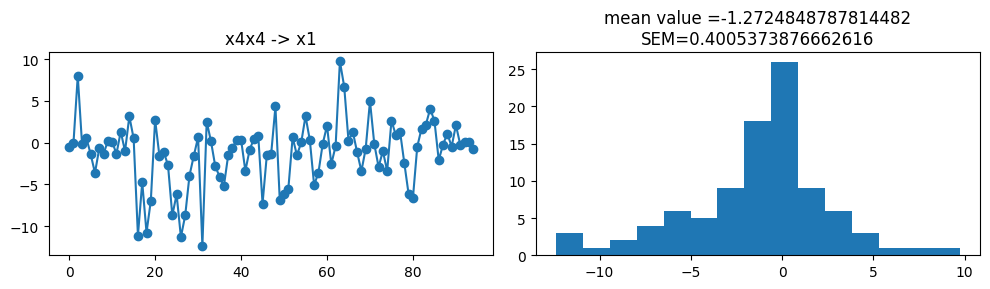

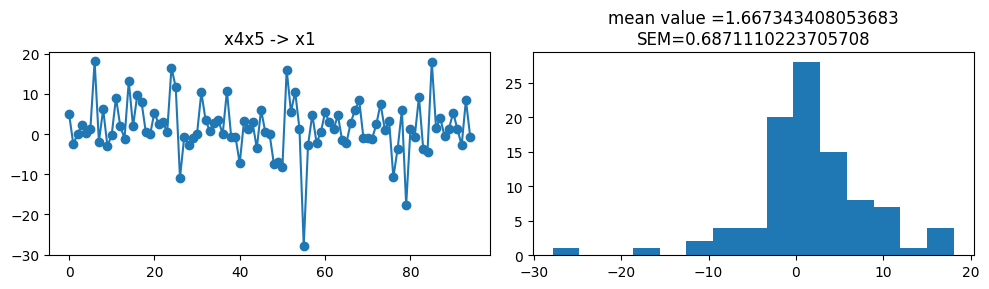

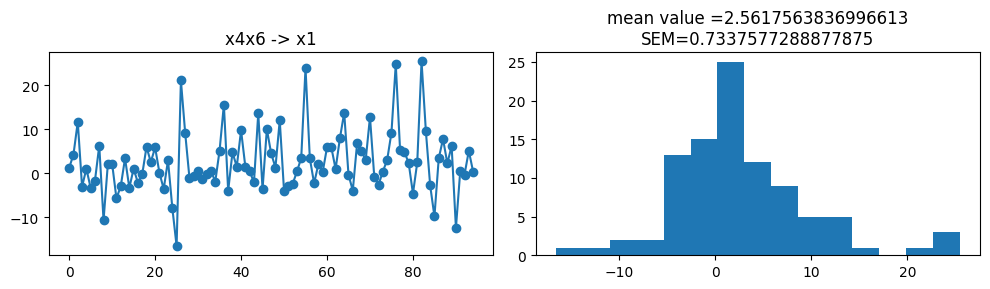

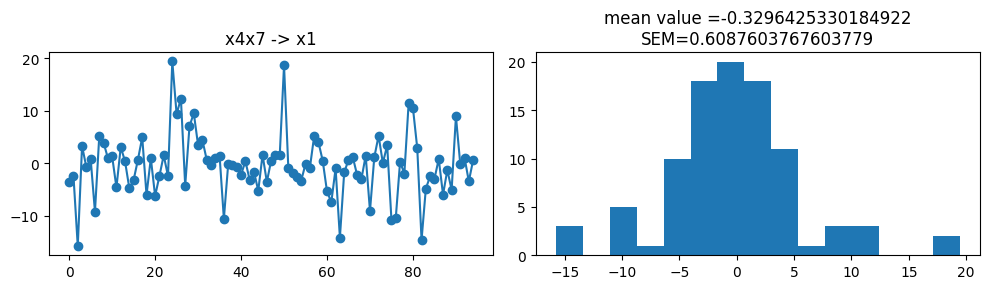

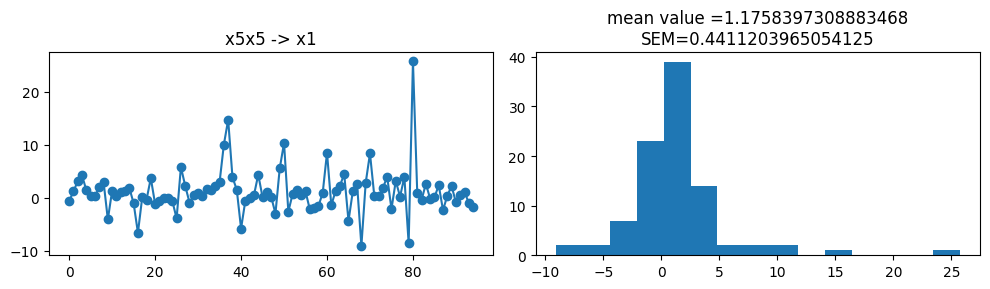

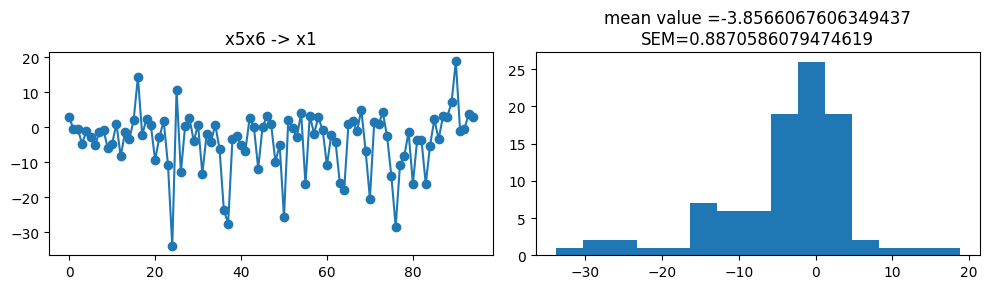

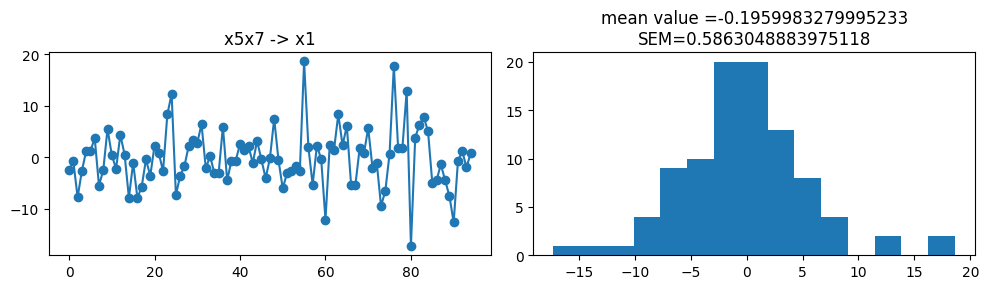

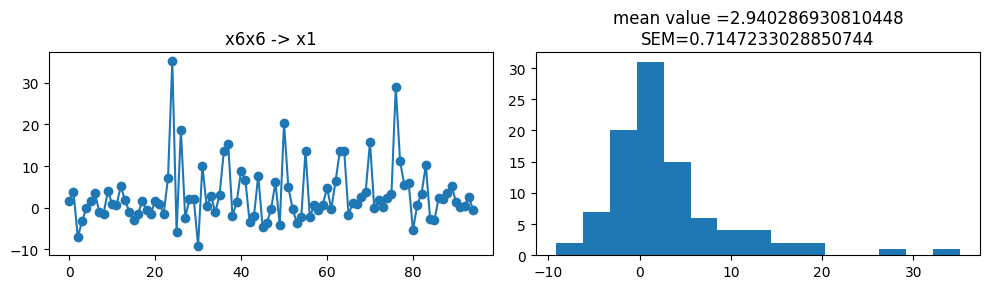

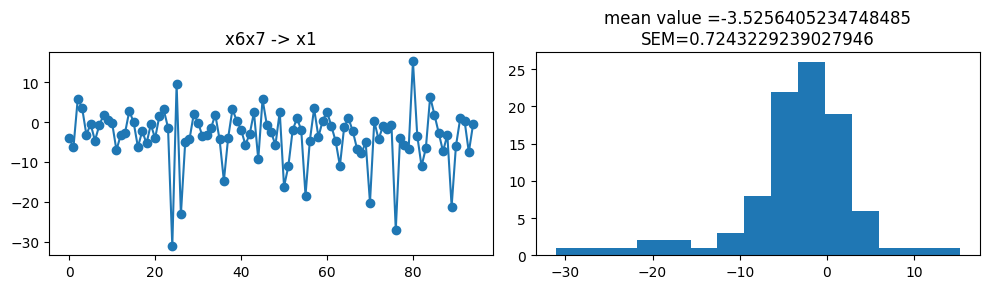

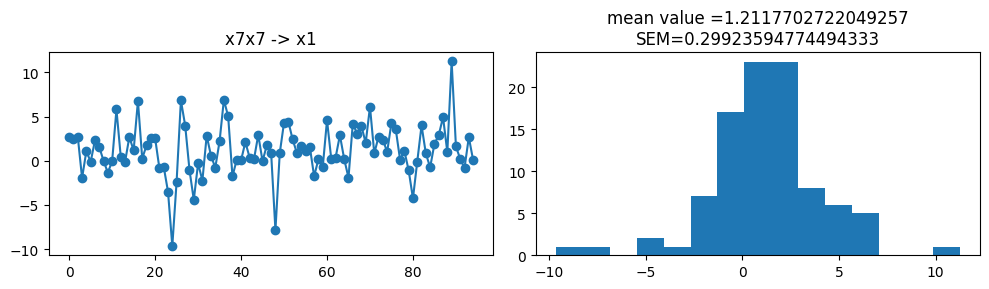

In [ ]:
#Higher-order interaction on node x1

for l in range(len(coeff_labels)):
    list=[eeg_subjects[i].values[l,0] for i in range(n_ensemble)]

    plt.figure(figsize=(10,3))

    plt.subplot(1,2,1)
    plt.plot(list,marker="o")
    plt.title(coeff_labels[l]+" -> x1")

    plt.subplot(1,2,2)
    plt.hist(list,bins=15)
    plt.title("mean value ="+str(np.mean(list))+"\nSEM="+str(np.std(list)/np.sqrt(n_ensemble-1)))

    plt.tight_layout()

plt.show()    

C:\Users\USER\AppData\Local\Temp\ipykernel_10768\867656731.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10,3))


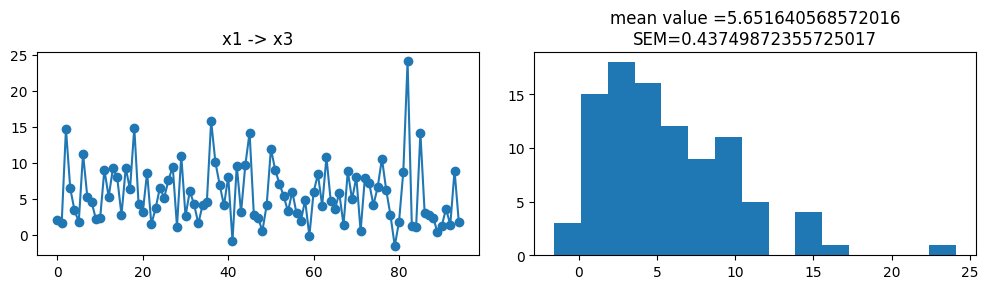

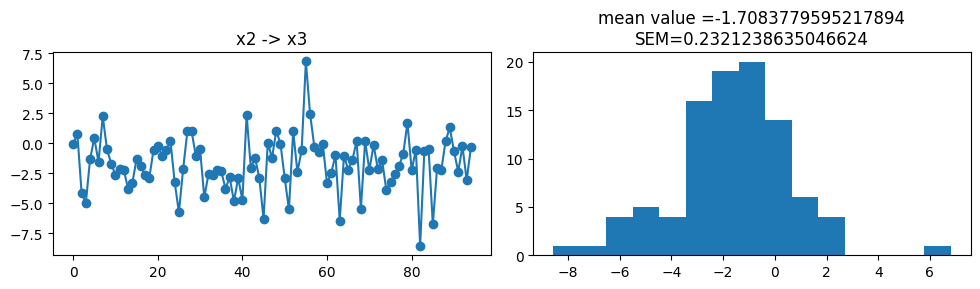

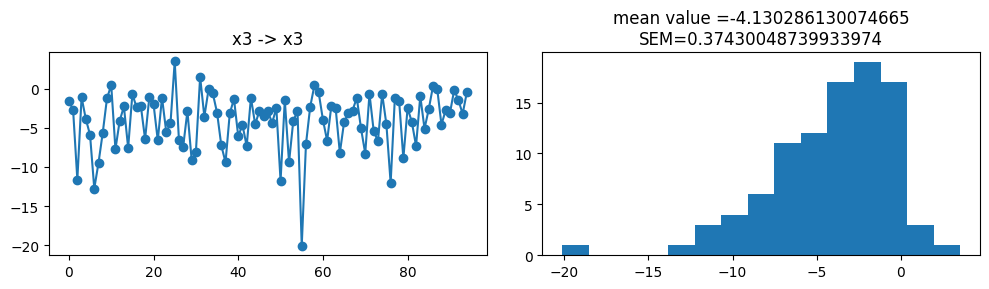

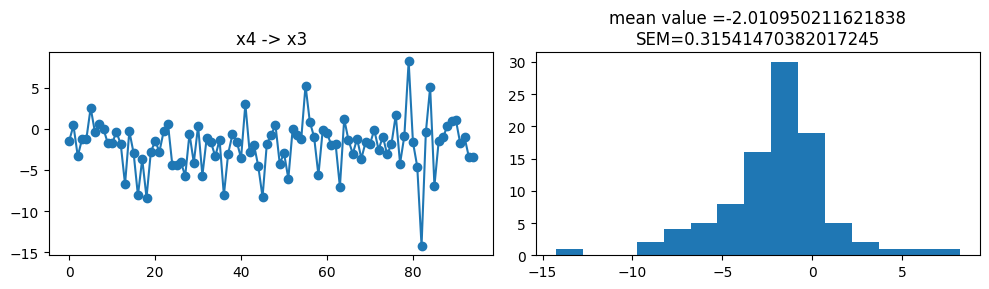

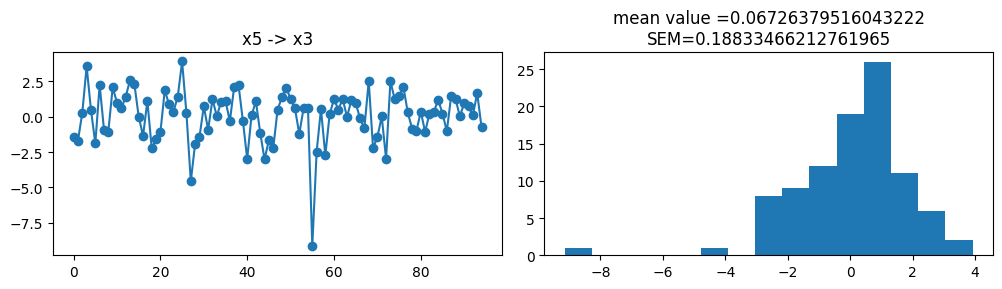

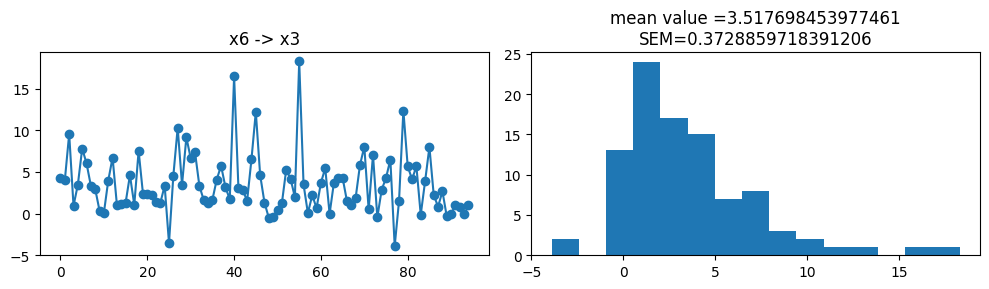

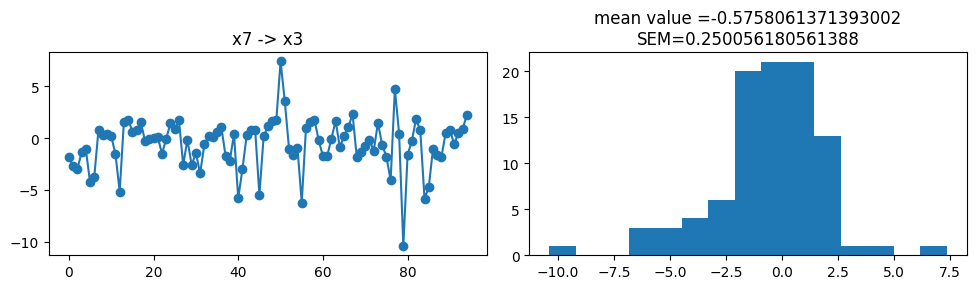

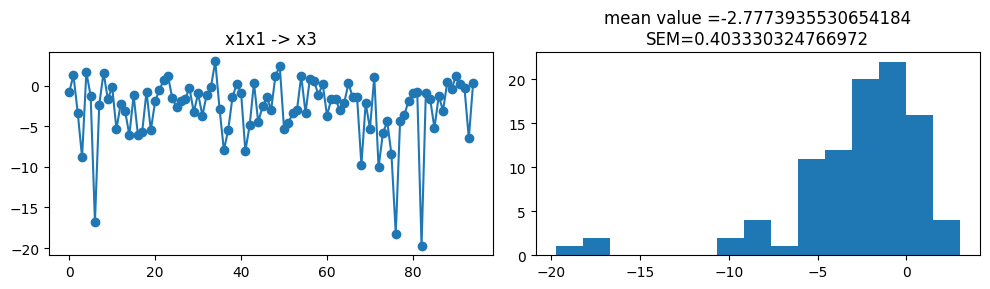

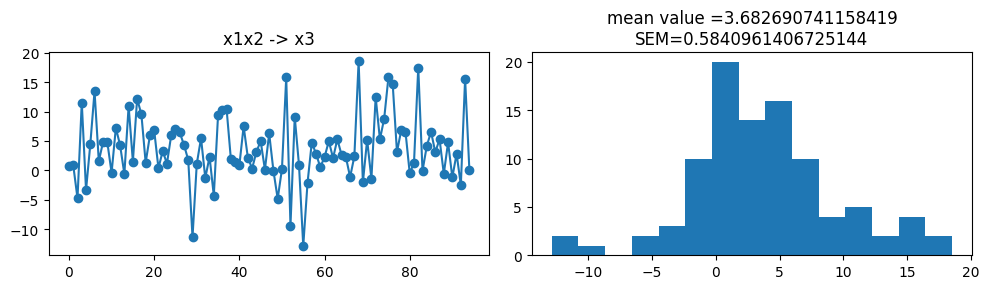

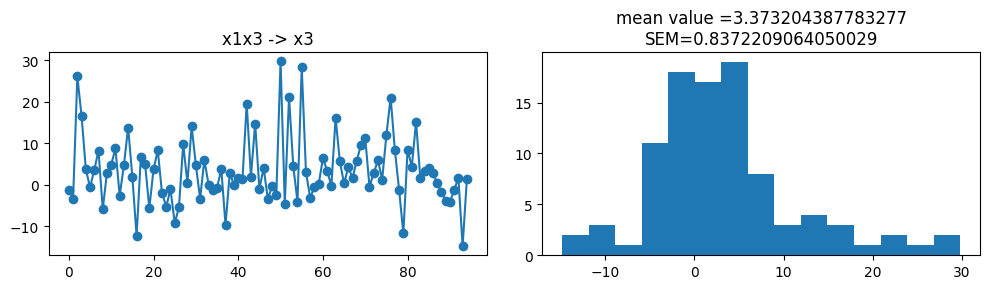

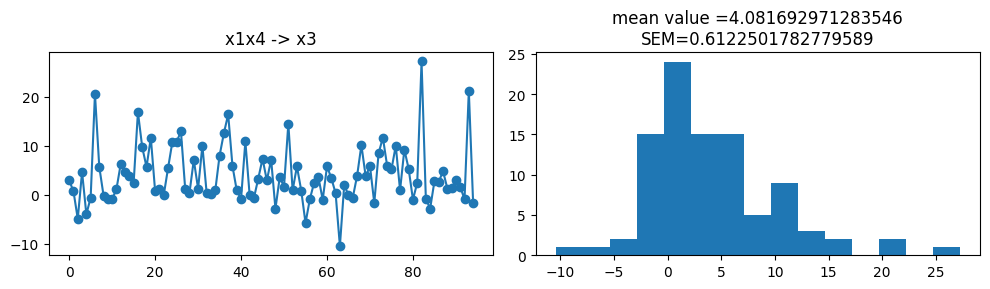

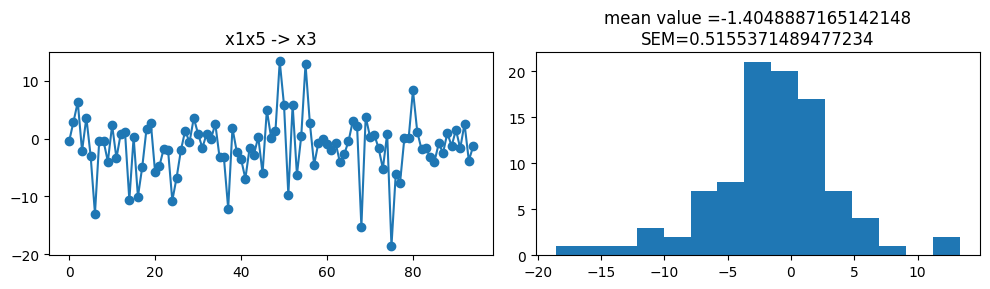

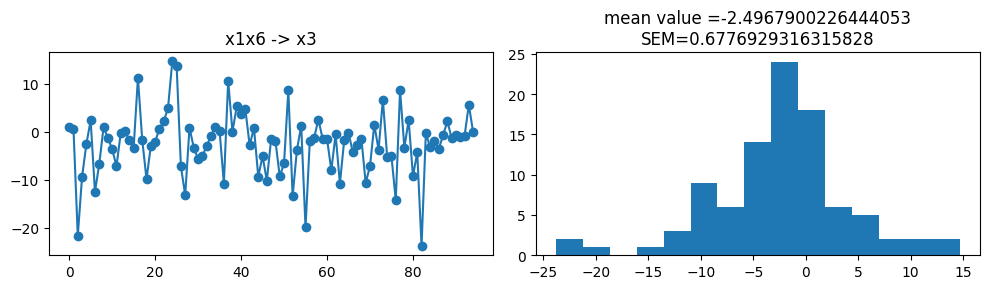

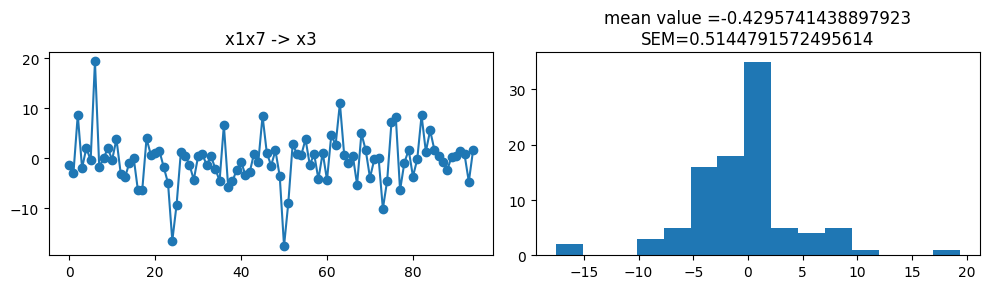

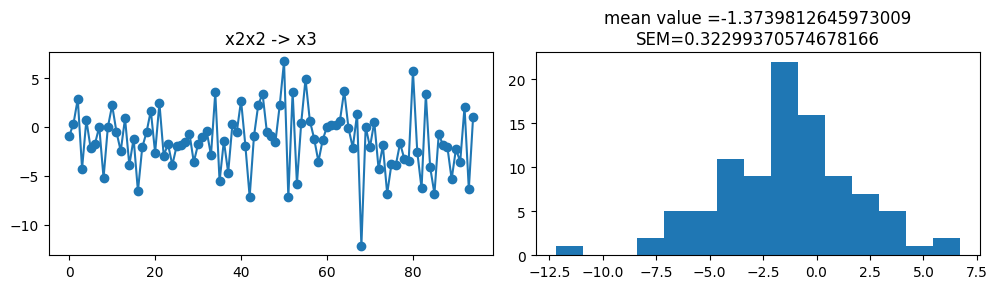

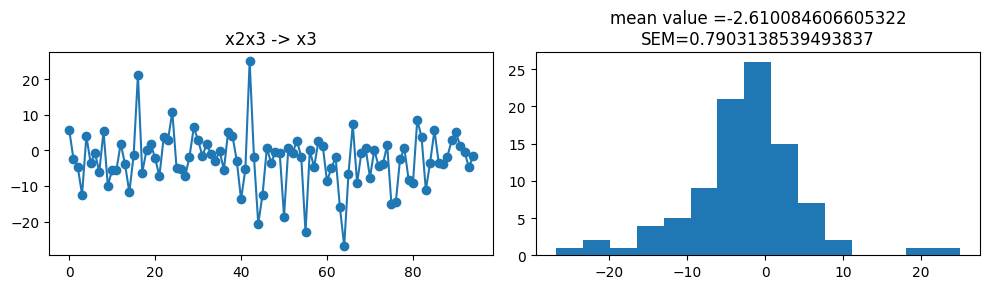

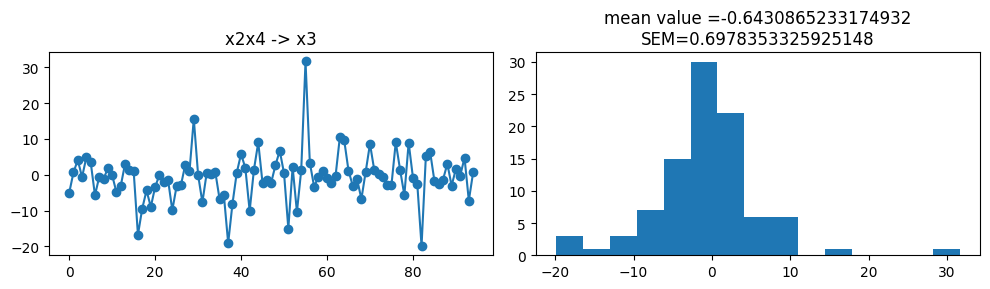

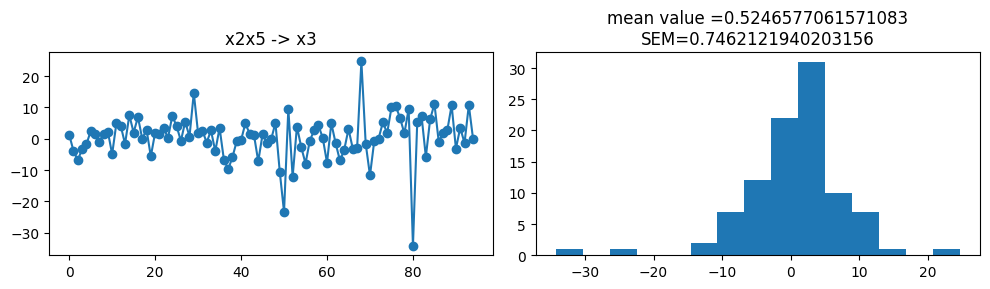

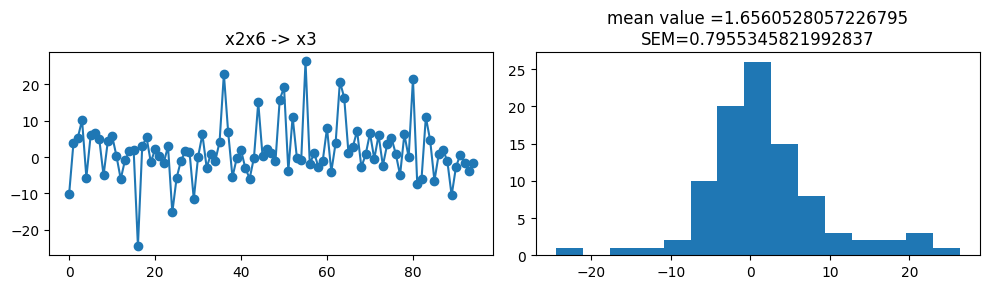

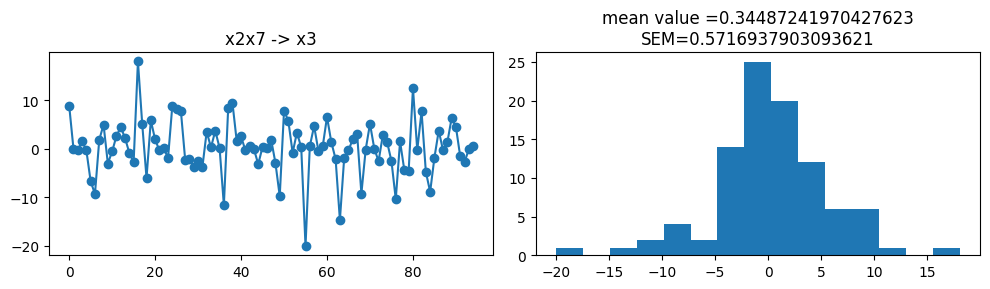

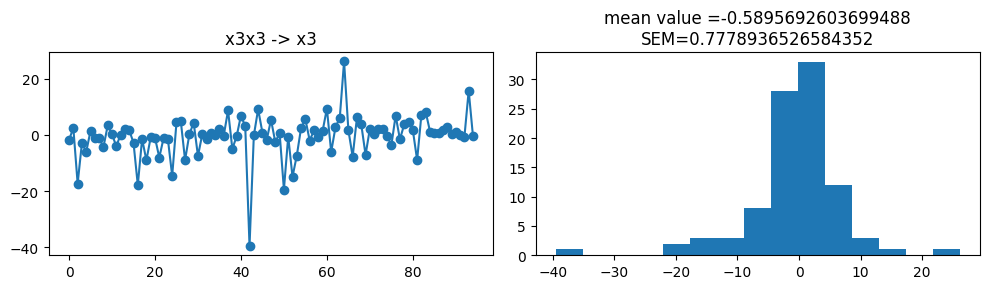

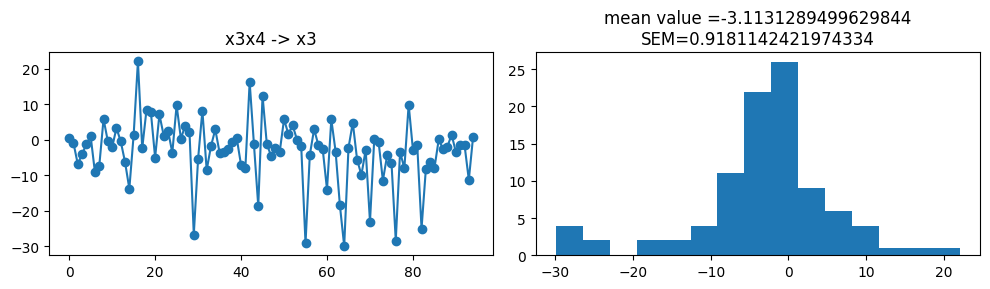

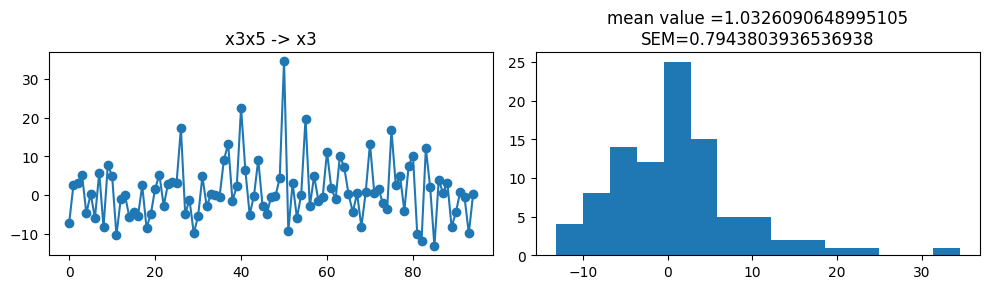

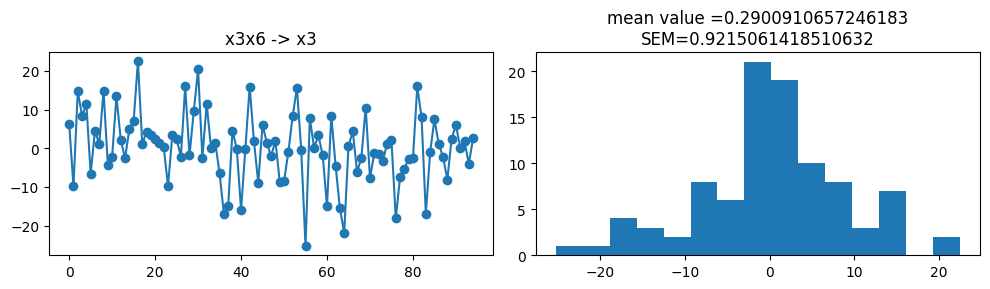

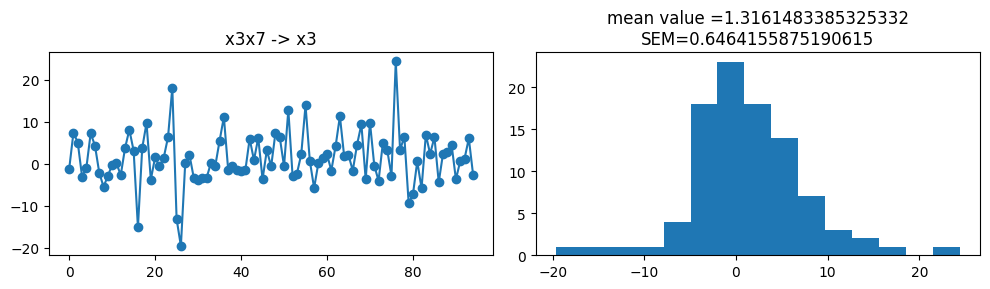

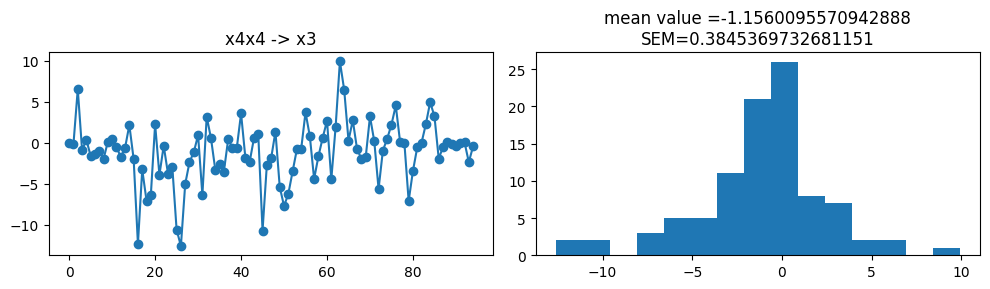

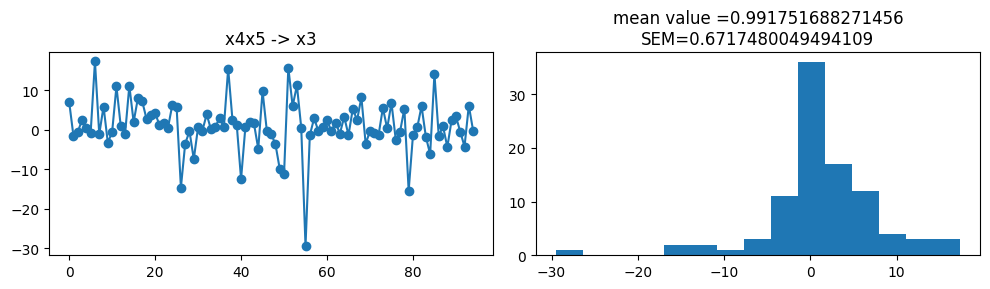

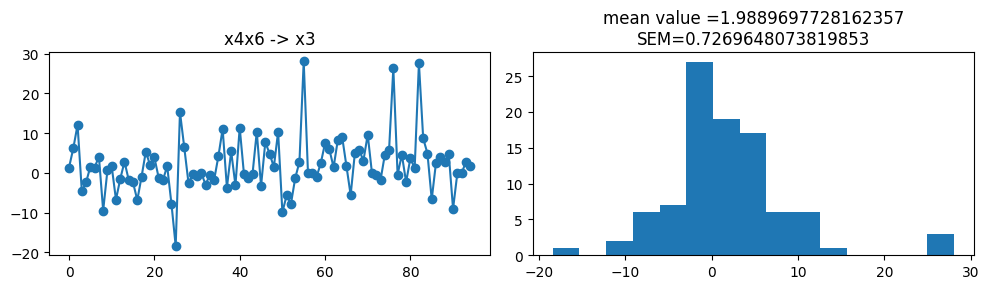

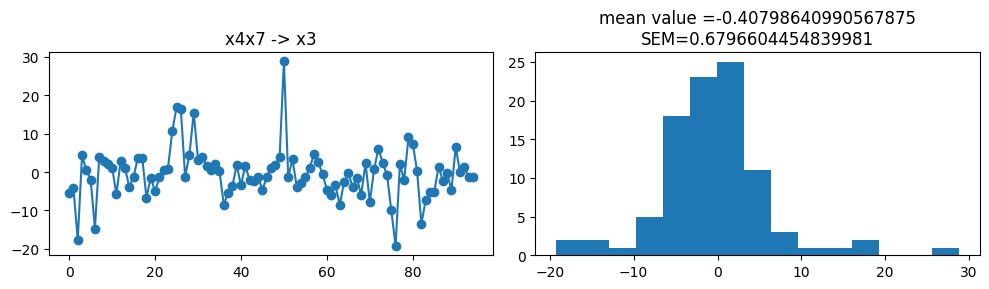

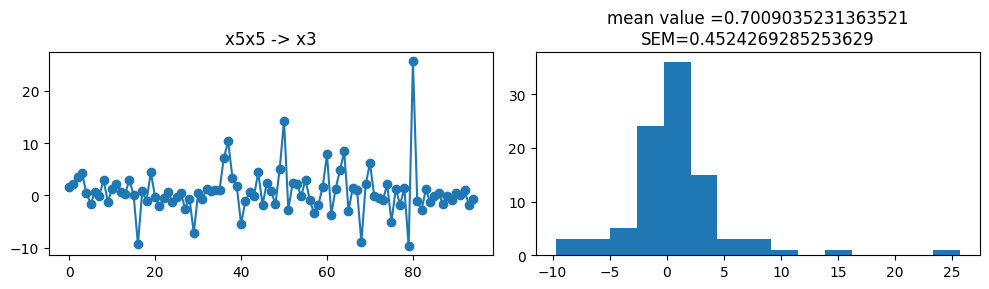

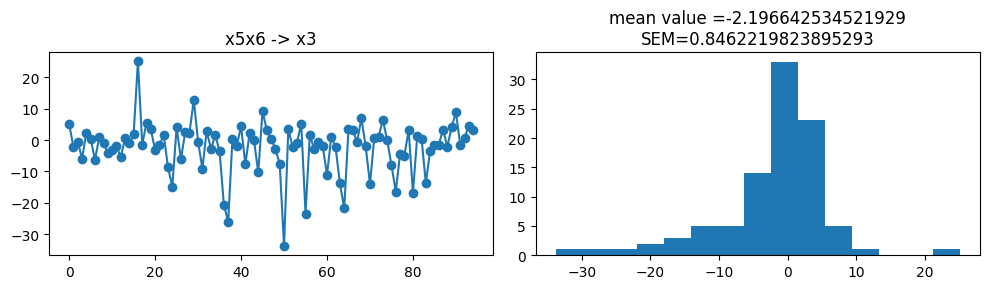

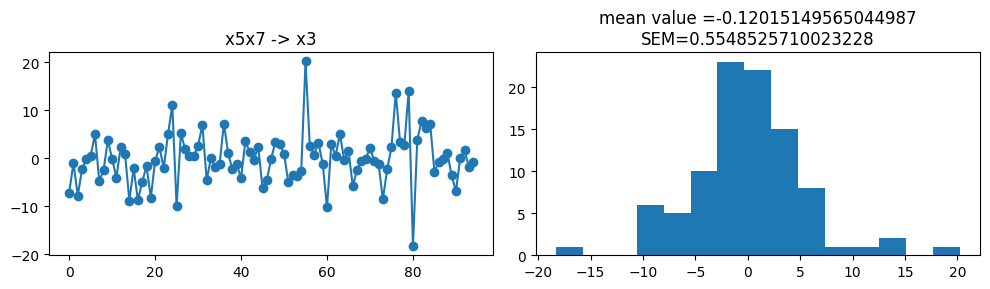

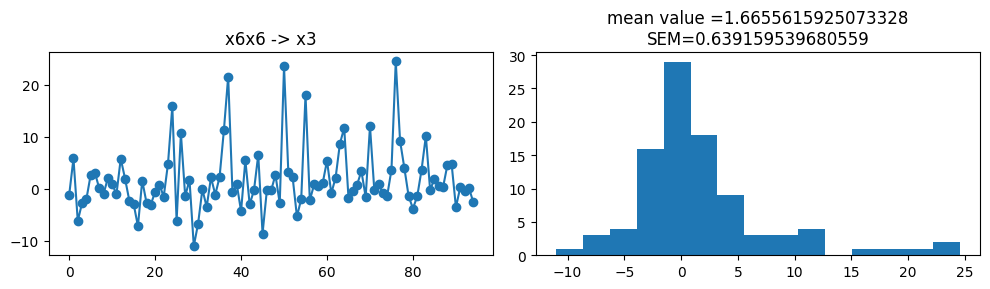

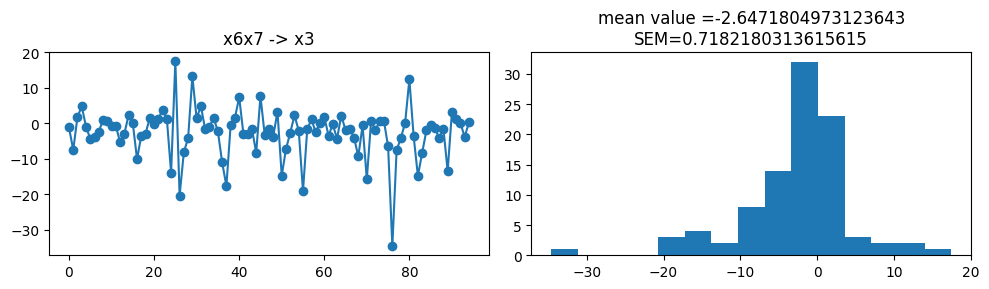

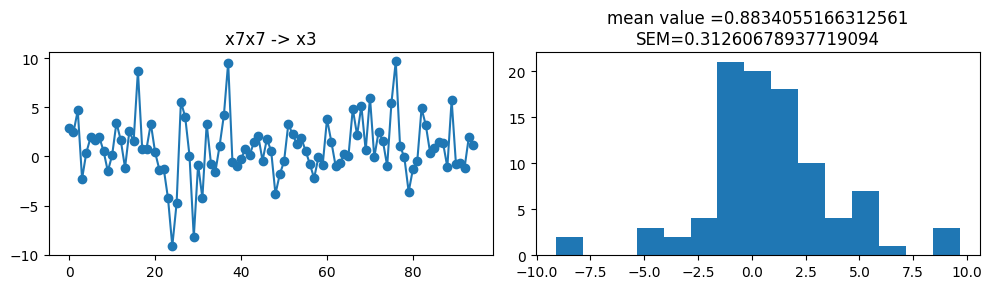

In [ ]:
#interaction on node x3

for l in range(len(coeff_labels)):
    list=[eeg_subjects[i].values[l,2] for i in range(n_ensemble)]

    plt.figure(figsize=(10,3))

    plt.subplot(1,2,1)
    plt.plot(list,marker="o")
    plt.title(coeff_labels[l]+" -> x3")

    plt.subplot(1,2,2)
    plt.hist(list,bins=15)
    plt.title("mean value ="+str(np.mean(list))+"\nSEM="+str(np.std(list)/np.sqrt(n_ensemble-1)))

    plt.tight_layout()

plt.show()    

Text(0.5, 1.0, 'fluctuation of weights over all of the subjects')

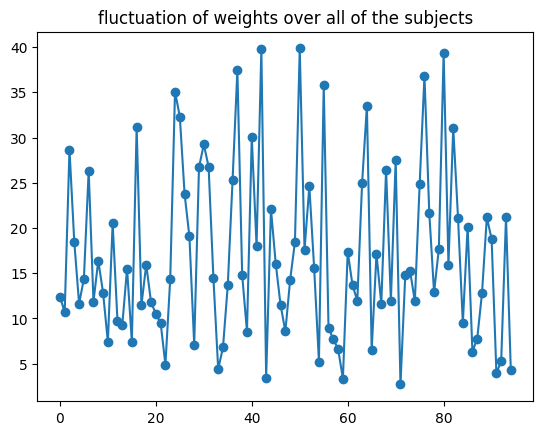

In [15]:
plt.figure()
plt.plot([np.max(np.abs(eeg_subjects[i].values)) for i in range(n_ensemble)],marker="o")
plt.title("fluctuation of weights over all of the subjects")

In [16]:
print(drift_models[0])
print(drift_models[0].shape)

             0         1          2         3          4          5          6
x1    1.926995  1.816544   2.020495  2.168532   0.712264   0.599537   0.434401
x2   -1.383408 -0.916324  -0.071718 -1.053375  -0.427171   0.460351   0.492712
x3   -1.139666 -0.929128  -1.511417 -0.503843   0.742557  -0.438107  -0.111318
x4   -1.401115 -1.054408  -1.465208 -2.000495  -1.767485  -1.406075  -1.611738
x5    0.611053 -0.148818  -1.430913  0.137437  -1.886659  -2.103554  -1.649798
x6    1.191885  3.287669   4.214763  2.111146   4.782046   5.029664   4.946914
x7    0.351443 -2.177577  -1.833983 -0.349445  -3.241749  -3.307473  -3.138201
x1x1 -0.400665 -1.217532  -0.801301 -0.544724  -0.771424  -0.415303  -0.415305
x1x2  2.577260  1.442556   0.746052  1.278247  -1.219739  -1.359524  -1.027773
x1x3 -2.310798 -2.099415  -1.171599 -0.242110  -1.473314  -2.386668  -2.013554
x1x4  2.394112  4.028585   2.968758  1.709619   4.451139   4.270678   3.611898
x1x5 -0.941211 -0.526291  -0.455224 -0.678066   2.99

Text(0.5, 0, 'Subjects')

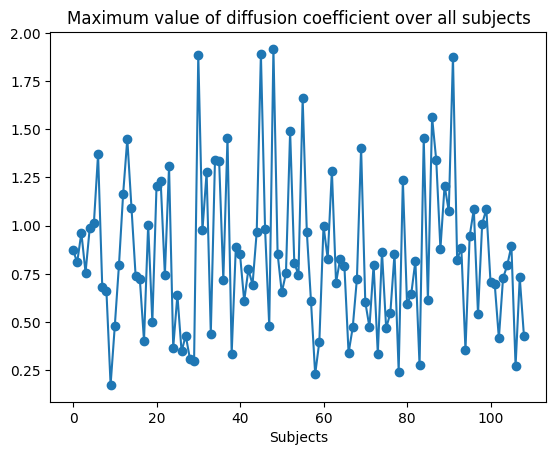

In [17]:

#P_ij calculation, Diffusion zeroth-order term as a matrix
diffusion_models=[]

for i in range(n_subjects):

    arr=hints.kmcc(ts_array=eeg_t1avg[i],dt=1/fs,interaction_order=[0],estimation_mode="diffusion").get_coefficients().values.flatten()
    d2=np.zeros((n_groups,n_groups))

    counter=-1

    for k in range(n_groups):
        for j in range(k,n_groups):

            counter+=1
            d2[k,j]=d2[j,k]=arr[counter]

    
    
    diffusion_models.append(d2)

plt.figure()
plt.plot([np.max(np.abs(diffusion_models[i])) for i in range(n_subjects)],marker="o")
plt.title("Maximum value of diffusion coefficient over all subjects")  
plt.xlabel("Subjects")  


In [18]:
d2_matrix_mean=np.zeros((n_groups,n_groups))
d2_matrix_sem=np.zeros((n_groups,n_groups))

for i in range(n_subjects):

    d2_matrix_mean=diffusion_models[i]+d2_matrix_mean
    
d2_matrix_mean=d2_matrix_mean/n_subjects

for i in range(n_subjects):

    d2_matrix_sem=d2_matrix_sem+(diffusion_models[i]-d2_matrix_mean)**2

d2_matrix_sem=np.sqrt(d2_matrix_sem/(n_subjects*(n_subjects-1)))    

In [19]:
print(pd.DataFrame(d2_matrix_sem).to_string())

          0         1         2         3         4         5         6
0  0.025617  0.023146  0.022740  0.024562  0.016315  0.016450  0.017174
1  0.023146  0.030988  0.028858  0.026866  0.028408  0.026357  0.024870
2  0.022740  0.028858  0.032371  0.029093  0.028382  0.029678  0.028423
3  0.024562  0.026866  0.029093  0.030858  0.023722  0.024585  0.025589
4  0.016315  0.028408  0.028382  0.023722  0.041928  0.038583  0.034617
5  0.016450  0.026357  0.029678  0.024585  0.038583  0.041082  0.037860
6  0.017174  0.024870  0.028423  0.025589  0.034617  0.037860  0.039157


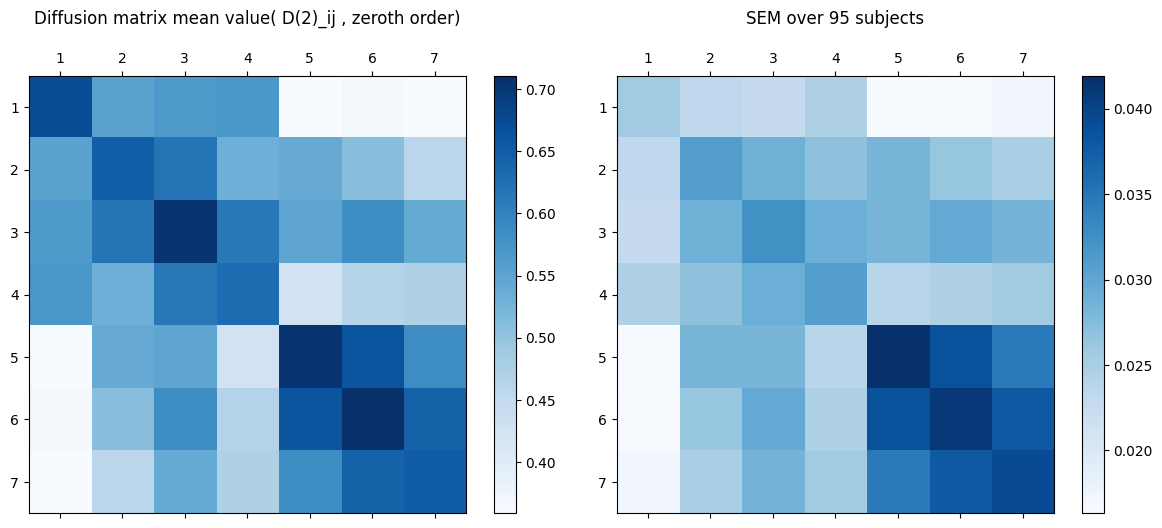

In [20]:
plt.figure(figsize=(12,5))

ax=plt.subplot(1,2,1)

im1=plt.imshow(d2_matrix_mean,"Blues")
plt.colorbar(im1)
ax.tick_params(top=True, labeltop=True, bottom=True, labelbottom=False)


ax.set_title("Diffusion matrix mean value( D(2)_ij , zeroth order)", y=1.1)

plt.xticks(np.arange(7),np.arange(1,8))
plt.yticks(np.arange(7),np.arange(1,8))


ax2=plt.subplot(1,2,2)

im2=plt.imshow(d2_matrix_sem,"Blues")

plt.colorbar(im2)

ax2.set_title("SEM over 95 subjects", y=1.1)

ax2.tick_params(top=True, labeltop=True, bottom=True, labelbottom=False)
plt.xticks(np.arange(7),np.arange(1,8))
plt.yticks(np.arange(7),np.arange(1,8))

plt.tight_layout()